# Aprende para um e executa para vários
Essa é a ideia por trás da transferência de aprendizado, pega-se uma rede já treinada e incorpora a sua rede. Baixar um modelo pré-treinado permite que você utilize o aprendizado de redes bem complexas e que demoraram muito tempo para serem treinadas.


In [1]:
# Baixando uma rede neural do tensorflow

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-08-19 15:45:02--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.128, 108.177.13.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  91.2MB/s    in 0.9s    

2020-08-19 15:45:03 (91.2 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [2]:
# Importando o modelo

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
# Iniciando as configurações para receber o modelo pré-treinado

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

In [3]:
# Carregando os pesos

pre_trained_model.load_weights(local_weights_file)

In [5]:
# Nesse passo é necessário travar os valores atuais da rede, para que não mudem no novo treinamento

for layer in pre_trained_model.layers:
    layer.trainable = False

In [6]:
# Visualizando o Modelo

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [7]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [8]:
# Flatten s saída para ter apenas 1 dimensão
x = layers.Flatten()(last_output)

# Adicionando uma camada full-connected a aprendizagem do modelo
x = layers.Dense(1024, activation='relu')(x)

# Regularizando, removendo 20% dos neurônios com valore iguais
x = layers.Dropout(0.2)(x)                  

# Nosso classificador terá uma saída binária (0, 1), a última camada então terá ativação sigmoid
x = layers.Dense  (1, activation='sigmoid')(x)           

In [9]:
from tensorflow.keras.optimizers import RMSprop

# Criando um novo modelo a partir do modelo pré-treinado
model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


### Tarefa
Nessa tarefa classificaremos cachorros e gatos a partir de imagens reais.

In [10]:
# Baixando as imagens

!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

--2020-08-19 15:59:19--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.214.128, 173.194.215.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   183MB/s    in 0.4s    

2020-08-19 15:59:19 (183 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [11]:
# Descompacta as imagens

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


# Diretórios com as imagens que serão usada como treinamento
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Diretórios com as imagens que serão usada como treinamento
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Carregando as imagens para o treinamento utilizando argumentos para alterar as imagens
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Carregando as imagens para a validação. Não é necessário alterar as imagens para validá-las
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 149s - loss: 0.3275 - accuracy: 0.8675 - val_loss: 0.1548 - val_accuracy: 0.9440
Epoch 2/20
100/100 - 148s - loss: 0.2142 - accuracy: 0.9195 - val_loss: 0.0989 - val_accuracy: 0.9660
Epoch 3/20
100/100 - 149s - loss: 0.2287 - accuracy: 0.9150 - val_loss: 0.3318 - val_accuracy: 0.8970
Epoch 4/20
100/100 - 149s - loss: 0.2025 - accuracy: 0.9220 - val_loss: 0.1277 - val_accuracy: 0.9630
Epoch 5/20
100/100 - 148s - loss: 0.1852 - accuracy: 0.9315 - val_loss: 0.1684 - val_accuracy: 0.9410
Epoch 6/20
100/100 - 149s - loss: 0.1875 - accuracy: 0.9375 - val_loss: 0.1236 - val_accuracy: 0.9600
Epoch 7/20
100/100 - 156s - loss: 0.1836 - accuracy: 0.9335 - val_loss: 0.0882 - val_accuracy: 0.9730
Epoch 8/20
100/100 - 152s - loss: 0.1730 - accuracy: 0.9395 - val_loss: 0.0962 - val_accuracy: 0.9690
Epoch 9/20
100/100 - 151s - loss: 0.1692 - accuracy: 0.9410 - val_loss: 0.0925 - val_accuracy: 0.9720
Epoch 10/20
100/100 - 153s - loss: 0.1379 - accuracy: 0.9535 - val_loss: 0.1601 - 

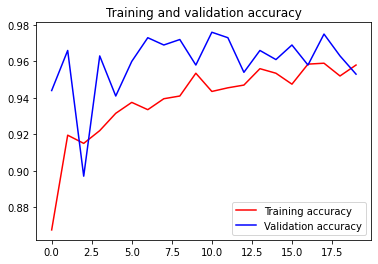

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()